In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#from keras.applications.mobilenet import MobileNet
#from sklearn.metrics import roc_auc_score
#from sklearn.metrics import roc_curve
#from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
imageSize=150
train_dir = "../input/kermany2018/oct2017/OCT2017 /train/"
test_dir =  "../input/kermany2018/oct2017/OCT2017 /test/"
# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):

    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
#X_train, y_train = get_data(train_dir) # Un-comment to use full dataset: Step 1 of 2
X_test, y_test= get_data(test_dir)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_test, y_test, test_size=0.2) # Re-comment to use full dataset: Step 2 of 2

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)
y_testHot = to_categorical(y_test, num_classes = 4)

100%|██████████| 243/243 [00:03<00:00, 65.37it/s]


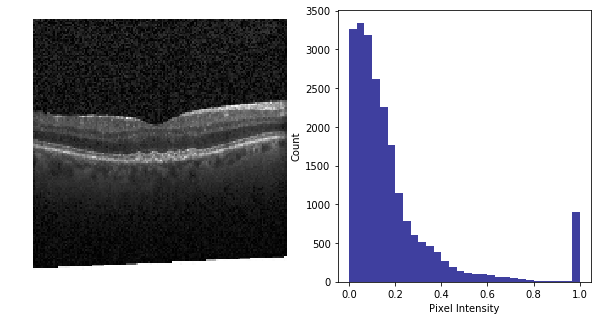

In [3]:
def plotHistogram(a):

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

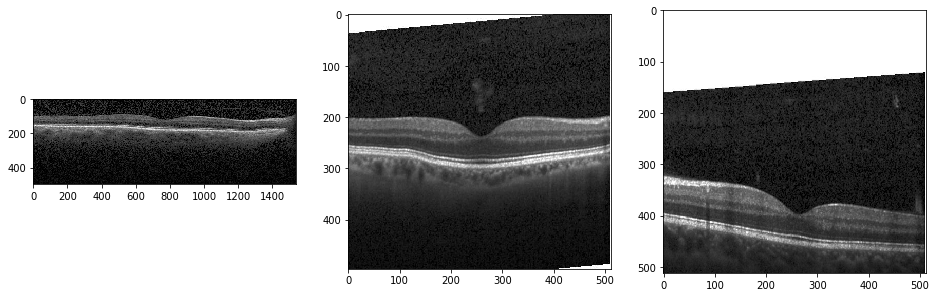

In [4]:
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/NORMAL/**')
def plotThreeImages(images):
    r = random.sample(images, 3)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
plotThreeImages(multipleImages)

Normal


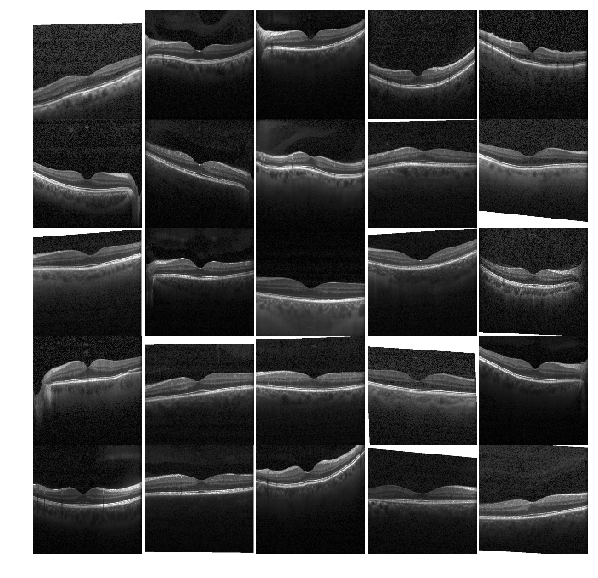

In [5]:
print("Normal")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

CNV


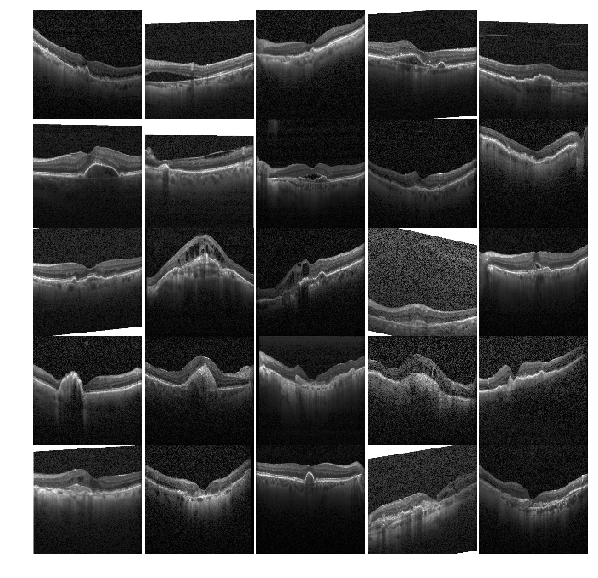

In [6]:
print("CNV")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/CNV/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DME


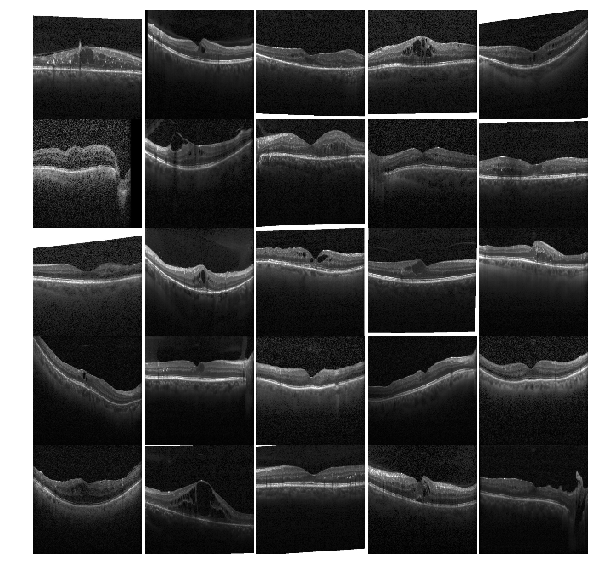

In [7]:
print("DME")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/DME/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

DRUSEN


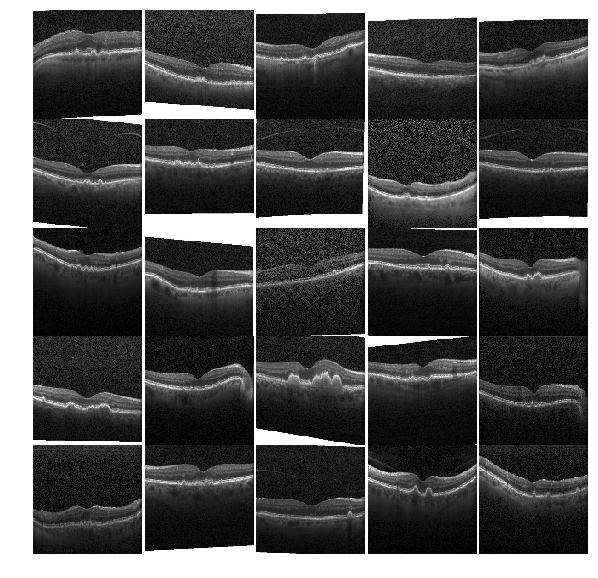

In [8]:
print("DRUSEN")
multipleImages = glob('../input/kermany2018/oct2017/OCT2017 /train/DRUSEN/**')
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}


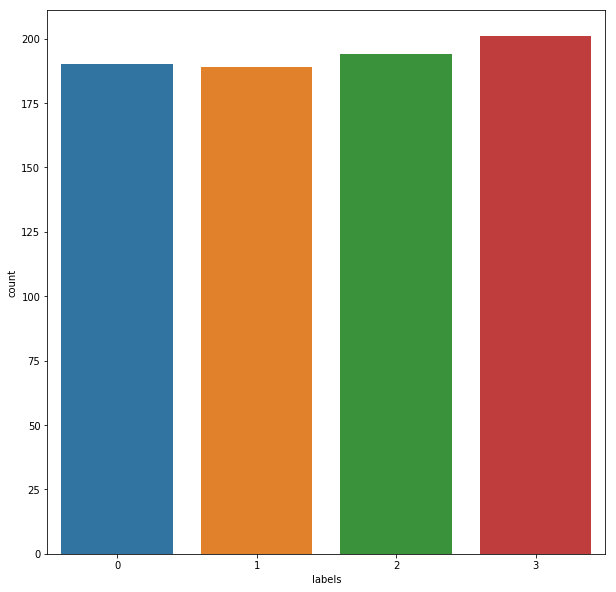

In [9]:
map_characters = {0: 'Normal', 1: 'CNV', 2: 'DME', 3: 'DRUSEN'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [10]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):

    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [17]:
class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        return self.relu(self.batchnorm(self.conv(x)))


In [ ]:
class Raiden_block(nn.Module):
    def __init__(
        self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
    ):
        super(Raiden_block, self).__init__()
        self.branch1 = conv_block(in_channels, out_1x1, kernel_size=(1, 1))
self.branch2 = nn.Sequential(
conv_block(in_channels, red_3x3, kernel_size=(1, 1)),
conv_block(red_3x3, out_3x3, kernel_size=(3, 3), padding=(1, 1)),
)

self.branch3 = nn.Sequential(
conv_block(in_channels, red_5x5, kernel_size=(1, 1)),
conv_block(red_5x5, out_5x5, kernel_size=(5, 5), padding=(2, 2)),
)

self.branch4 = nn.Sequential(
nn.MaxPool2d(kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
conv_block(in_channels, out_1x1pool, kernel_size=(1, 1)),
)

def forward(self, x):
return torch.cat(
[self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1
)

In [ ]:
class RaidenNet(nn.Module):
    def __init__(self, aux_logits=True, num_classes=1000):
        super(RaidenNet, self).__init__()
        assert aux_logits == True or aux_logits == False
        self.aux_logits = aux_logits

# Write in_channels, etc, all explicit in self.conv1, rest will write to
# make everything as compact as possible, kernel_size=3 instead of (3,3)
self.conv1 = conv_block(
in_channels=3,
out_channels=64,
kernel_size=(7, 7),
stride=(2, 2),
padding=(3, 3),
)

self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
self.conv2 = conv_block(64, 192, kernel_size=3, stride=1, padding=1)
self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

# In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
self raiden.3a = raiden_block(192, 64, 96, 128, 16, 32, 32)
self.raiden3b = raiden_block(256, 128, 128, 192, 32, 96, 64)
self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

self.raiden4a = raiden_block(480, 192, 96, 208, 16, 48, 64)
self.raiden4b = raiden_block(512, 160, 112, 224, 24, 64, 64)
self.raiden4c = raiden_block(512, 128, 128, 256, 24, 64, 64)
self.raiden4d = raiden_block(512, 112, 144, 288, 32, 64, 64)
self.raiden4e = raiden_block(528, 256, 160, 320, 32, 128, 128)
self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

self.raiden5a = raiden_block(832, 256, 160, 320, 32, 128, 128)
self.raiden5b = raiden_block(832, 384, 192, 384, 48, 128, 128)

self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
self.dropout = nn.Dropout(p=0.4)
self.fc1 = nn.Linear(1024, num_classes)

if self.aux_logits:
self.aux1 = raidenAux(512, num_classes)
self.aux2 = raidenAux(528, num_classes)
else:
self.aux1 = self.aux2 = None

def forward(self, x):
x = self.conv1(x)
x = self.maxpool1(x)
x = self.conv2(x)
# x = self.conv3(x)
x = self.maxpool2(x)

x = self.raiden3a(x)
x = self.raiden3b(x)
x = self.maxpool3(x)

x = self.raiden4a(x)

# Auxiliary Softmax classifier 1
if self.aux_logits and self.training:
aux1 = self.aux1(x)

x = self.raiden4b(x)
x = self.raiden4c(x)
x = self.raiden4d(x)

# Auxiliary Softmax classifier 2
if self.aux_logits and self.training:
aux2 = self.aux2(x)

x = self.raiden4e(x)
x = self.maxpool4(x)
x = self.raiden5a(x)
x = self.raiden5b(x)
x = self.avgpool(x)
x = x.reshape(x.shape[0], -1)
x = self.dropout(x)
x = self.fc1(x)

if self.aux_logits and self.training:
return aux1, aux2, x
else:
return x

In [ ]:
class RaidenAux(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(RaidenAux, self).__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.7)
        self.pool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv = conv_block(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [20]:
from sklearn.utils import shuffle
X_trainRosReshaped, Y_trainRosHot = shuffle(X_trainRosReshaped, Y_trainRosHot, random_state=13)
X_testRosReshaped, Y_testRosHot = shuffle(X_testRosReshaped, Y_testRosHot, random_state=13)

Train on 756 samples, validate on 164 samples
Epoch 1/5
756/756 [==============================] - 96s 127ms/step - loss: 1.0353 - acc: 0.5635 - val_loss: 0.7078 - val_acc: 0.7378
Epoch 2/5
756/756 [==============================] - 94s 124ms/step - loss: 0.5438 - acc: 0.8452 - val_loss: 0.5226 - val_acc: 0.8293
Epoch 3/5
756/756 [==============================] - 94s 124ms/step - loss: 0.4042 - acc: 0.8836 - val_loss: 0.4384 - val_acc: 0.8659
Epoch 4/5
756/756 [==============================] - 94s 124ms/step - loss: 0.3176 - acc: 0.9259 - val_loss: 0.3950 - val_acc: 0.8780
Epoch 5/5
756/756 [==============================] - 94s 125ms/step - loss: 0.2616 - acc: 0.9352 - val_loss: 0.3919 - val_acc: 0.8659

Keras CNN - accuracy: 0.8658536585365854 


             precision    recall  f1-score   support

     Normal       0.85      1.00      0.92        41
        CNV       0.76      0.93      0.84        41
        DME       0.97      0.73      0.83        41
     DRUSEN       0.94    

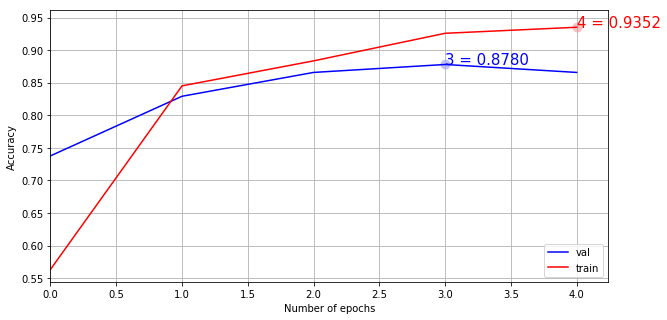

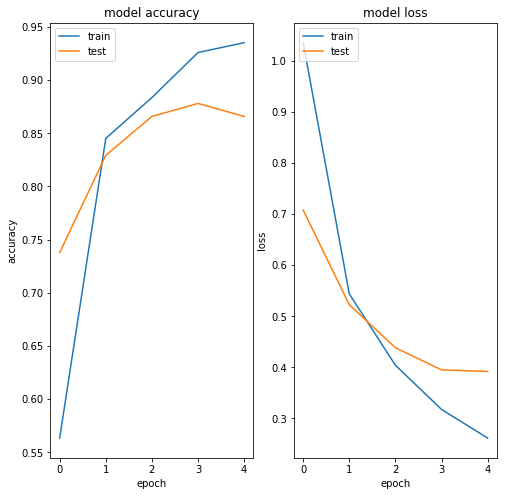

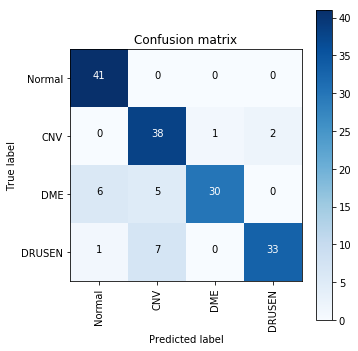

In [21]:
model = RaidenNet(aux_logits=True, num_classes=4)
model.fit(X_trainRosReshaped, Y_train_RosHot, validation_data = (X_testRosReshaped, Y_testRosHot). metrics = ['accuracy'])